# Switching on non-delta exponential distribution metallicity scatter that is already in Bagpipes

In [1]:
import bagpipes as pipes
# setting bagpipes R_spec to as high as possible for perfect generation of models
pipes.config.R_spec = 4340
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy
import pandas as pd
from PyAstronomy import pyasl
import seaborn as sns
import pandas as pd
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70., Om0=0.3)
from scipy.optimize import curve_fit

Starting dense_basis. please wait ~ a minute for the FSPS backend to initialize.


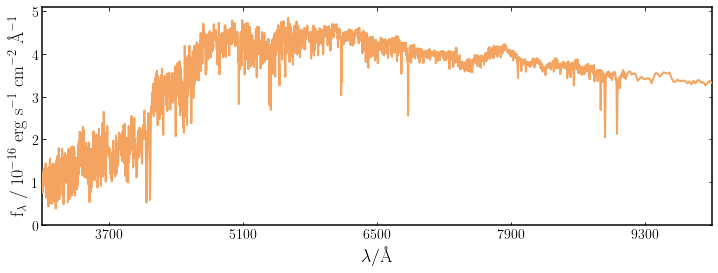

(<Figure size 864x288 with 1 Axes>,
 [<AxesSubplot:xlabel='$\\lambda / \\mathrm{\\AA}$', ylabel='$\\mathrm{f_{\\lambda}}\\ \\mathrm{/\\ 10^{-16}\\ erg\\ s^{-1}\\ cm^{-2}\\ \\AA^{-1}}$'>])

In [2]:
# create a simple spectrum before swapping, to be compared after swapping
constant = {}
constant['massformed'] = 10
constant['metallicity'] = 1.0
constant['age_max'] = 10
constant['age_min'] = 1

model_components = {}
model_components['constant'] = constant
model_components['redshift'] = 0.04

obs_wavs = np.arange(3000., 10000., 1.)
pre_change_model = pipes.model_galaxy(model_components, spec_wavs=obs_wavs)
pre_change_model.plot()

In [16]:
#swap out the function within chemical_enrichment_history.py to switch from delta to exponential distribution
import bagpipes.config as config
def __init__(self, model_comp, sfh_weights):

    self.zmet_vals = config.metallicities
    self.zmet_lims = config.metallicity_bins

    self.grid_comp = {}
    self.grid = np.zeros((self.zmet_vals.shape[0],
                          config.age_sampling.shape[0]))

    for comp in list(sfh_weights):
        if comp is not "total":
            self.grid_comp[comp] = self.exp(model_comp[comp],
                                              sfh_weights[comp])

            self.grid += self.grid_comp[comp]

pipes.models.chemical_enrichment_history.__init__ = __init__

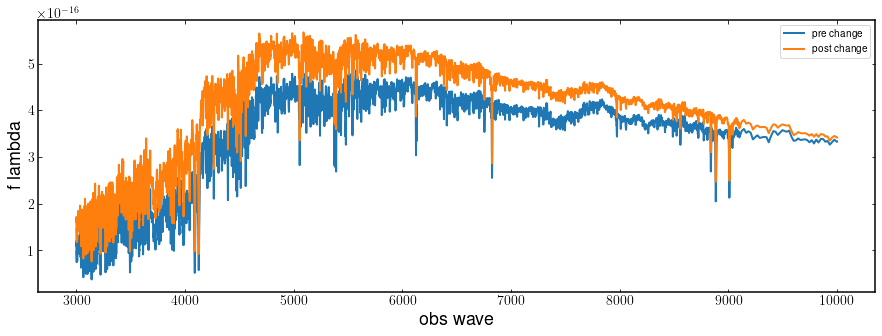

In [23]:
# create a simple spectrum after swapping
post_change_model = pipes.model_galaxy(model_components, spec_wavs=obs_wavs)
fig, ax = plt.subplots(figsize=[15,5])
ax.plot(obs_wavs, pre_change_model.spectrum[:,1], label='pre change')
ax.plot(obs_wavs, post_change_model.spectrum[:,1], label='post change')
ax.legend()
ax.set_xlabel(r'obs wave')
ax.set_ylabel(r'f lambda')
plt.show()

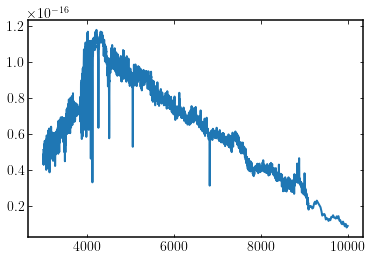

In [18]:
plt.plot(obs_wavs, post_change_model.spectrum[:,1]-pre_change_model.spectrum[:,1])

## There is difference between using exp and delta reflected on modelled spectra, quite a lot of difference in fact
Proceed to fitting with exp on, on Yirui's simulated galaxy (no dust no obs noise perturbation)

In [25]:
def mask_em(wave):
    """ from maskem.pro OII, Hgama, Hbeta, OIII, OIII: Vacuum """

    
    lines_vac = np.array([3727.092,3729.875,4102.892, 4341.692,4862.683,4960.295,5008.24])
    lines = pyasl.vactoair2(lines_vac)
    
    mask = []
    for i in range(lines.shape[0]):
        masksize = 5

        ind = np.where((wave>lines[i]-masksize) & (wave<lines[i]+masksize))
        mask.extend(ind[0])

    # MgII  2796.352 ,2803.531 
    #ind = np.where((wave>2766.4) & (wave<2833.5))

    # remove everything bluewards of 3000A
    ind = np.where(wave<3000)
    mask.extend(ind[0])    

    return mask

def load_uds_spectrum_mask(ID,z):

    # load spectral data
    spectrum = np.loadtxt(fname='../../Yirui_test_cube/snap119/with_PSF/no_dust/Spectrum_'+
                          ID+".csv", delimiter=',', skiprows=1)
    
    spectrum[:,1] *= 10**-16
    spectrum[:,2] *= 10**-16

    # blow up the errors associated with any bad points in the spectrum and photometry
    for i in range(len(spectrum)):
        if spectrum[i,1] == 0 or spectrum[i,2] <= 0:
            spectrum[i,1] = 0.
            spectrum[i,2] = 9.9*10**99.
    
    # nebular emission lines and interstellar absorption lines
    mask = mask_em(spectrum[:,0]/(1+z))
    spectrum[mask, 2] = 9.9*10**99.
    
    # O2 telluric
    mask = ((spectrum[:,0] > 7580.) & (spectrum[:,0] < 7650.))
    spectrum[mask, 2] = 9.9*10**99.

    #return bin(spectrum,4)
    return spectrum
    

def load_uds_mask(ID):
    z = 0.04
    spectrum = load_uds_spectrum_mask(ID,z)

    return spectrum

def get_fit_instructions(z=0.04):
    """ Set up the desired fit_instructions dictionary. """
    
    psb2 = {}
    psb2["age"] = (4, 14.)                     # Vary age between 4 Myr and 14 Gyr. In practice 
                                          # the code automatically limits this to the age of
                                          # the Universe at the observed redshift.
    psb2["tau"] = (0.3, 10.)                   # Vary tau between 300 Myr and 10 Gyr
    psb2["massformed"] = (6, 13)              # vary log_10(M*/M_solar) between 1 and 15
    psb2["metallicity"] = (0.01, 2.5)           # vary Z between 0.1 and 2.5 Z_solar
    psb2["metallicity_prior"] = "log_10"
    
    psb2["burstage"] = (0,2)                   # age of burst from 0 to 2Gyr
    psb2["alpha"] = (0.01,1000)               # decline of burst
    psb2["alpha_prior"] = "log_10"
    psb2["beta"] = 250.                    # rise of burst: fixed
    psb2["fburst"] = (0,1)
    
    fit_instructions = {}
    fit_instructions['psb2'] = psb2
    fit_instructions['redshift'] = (z-0.2*z, z+0.2*z)
    
    return fit_instructions

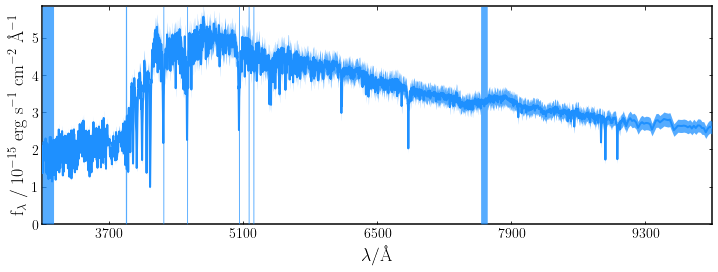

In [26]:
ID = '2xSc_07_EC_BH_vw1e4_ReposNoRFBNoRP_with_PSF_no_dust_SNR15_outshining_test'
z = 0.04

galaxy = pipes.galaxy(ID, load_uds_mask, photometry_exists=False)

fig = galaxy.plot()

In [27]:
fit_instructions = get_fit_instructions()
print(fit_instructions)

{'psb2': {'age': (4, 14.0), 'tau': (0.3, 10.0), 'massformed': (6, 13), 'metallicity': (0.01, 2.5), 'metallicity_prior': 'log_10', 'burstage': (0, 2), 'alpha': (0.01, 1000), 'alpha_prior': 'log_10', 'beta': 250.0, 'fburst': (0, 1)}, 'redshift': (0.032, 0.048)}


In [28]:
pipes.config.Rspec = 4340
runID = "exp_scatter_no_dust_bin_by_1_4340_Rspec"
fit = pipes.fit(galaxy, fit_instructions, run=runID)

fit.fit(verbose=False)


Bagpipes: fitting object 2xSc_07_EC_BH_vw1e4_ReposNoRFBNoRP_with_PSF_no_dust_SNR15_outshining_test


Completed in 3101.0 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
psb2:age                      11.494     12.265     12.742
psb2:alpha                   479.966    702.279    902.182
psb2:burstage                  0.603      0.623      0.640
psb2:fburst                    0.158      0.167      0.177
psb2:massformed               10.901     10.933     10.955
psb2:metallicity               2.465      2.486      2.496
psb2:tau                       0.539      1.044      1.896
redshift                       0.040      0.040      0.040




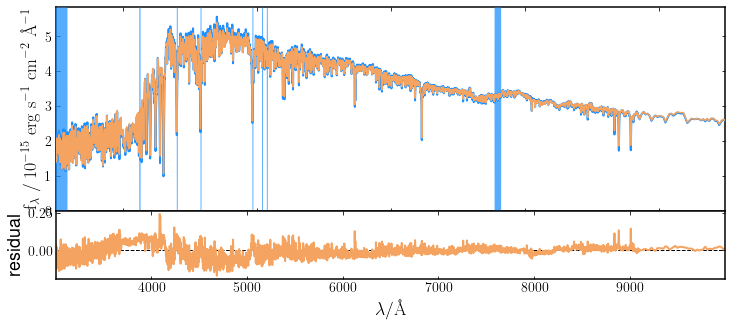

In [29]:
# Make the figure
matplotlib.rcParams.update({'font.size': 16})
params = {'legend.fontsize': 16,
          'legend.handlelength': 1}
matplotlib.rcParams.update(params)
matplotlib.rcParams['text.usetex'] = True
fit.posterior.get_advanced_quantities()

naxes=1
fig = plt.figure(figsize=(12, 5.*naxes))

gs1 = matplotlib.gridspec.GridSpec(4, 1, hspace=0., wspace=0.)
ax1 = plt.subplot(gs1[:3])
ax3 = plt.subplot(gs1[3])

mask = fit.galaxy.spectrum[:, 2] < 1.
fit.galaxy.spectrum[mask, 2] = 0.

y_scale = pipes.plotting.add_spectrum(fit.galaxy.spectrum, ax1)
pipes.plotting.add_spectrum_posterior(fit, ax1, y_scale=y_scale)

post_median = np.median(fit.posterior.samples["spectrum"], axis=0)

#ax1.plot(fit.galaxy.spectrum[:,0],
#         post_median*10**-y_scale,
#         color="black", lw=1.0,zorder=11)

ax3.axhline(0, color="black", ls="--", lw=1)
ax3.plot(fit.galaxy.spectrum[:,0],(post_median - fit.galaxy.spectrum[:,1])*10**-y_scale, color="sandybrown")
#ax1.set_xlim([3000,4200])
ax3.set_xlim(ax1.get_xlim())
ax3.set_xlabel("$\\lambda / \\mathrm{\\AA}$")
ax3.set_ylabel('residual')
fig.savefig('pipes/plots/'+runID+'/'+ID+'_fit.pdf')
plt.show()

In [30]:
fig = fit.plot_corner(save=True, show=True)

In [31]:
age_at_z = pipes.utils.cosmo.age(0).value
sim_data = np.loadtxt('../../Yirui_test_cube/snap119/2xSc_07_EC_BH_vw1e4_ReposNoRFBNoRP_snap119_SFH_at_diff_radius.txt')
model_sfh = sim_data[:,2]
model_ages = sim_data[:,0]
mask = model_ages > 0
model_ages = model_ages[mask].copy()
model_sfh = model_sfh[mask].copy()

In [32]:
def integrate_sfh(ages, sfh, Mstar=None):
    """ 
    takes a sfh and integrates it to return a cumulative SFH (normalized to run from 0 to 1) fraction of 
    mass formed
    """
    if Mstar is None:
        Mstar = np.trapz(y=sfh,x=ages)
    c_sfh = np.zeros(len(sfh))
    for i,sfhi in enumerate(sfh):
        c_sfh[i] = np.trapz(sfh[:i+1],x=ages[:i+1]/Mstar)
    return c_sfh

# extracted from bagpipes.models.star_formation_history.py, with a bit of tweaking
def psb_wild2020(age_list, age, tau, burstage, alpha, beta, fburst, Mstar):
    """
    A 2-component SFH for post-starburst galaxies. An exponential
    compoent represents the existing stellar population before the
    starburst, while a double power law makes up the burst.
    The weight of mass formed between the two is controlled by a
    fburst factor: thefraction of mass formed in the burst.
    For more detail, see Wild et al. 2020
    (https://ui.adsabs.harvard.edu/abs/2020MNRAS.494..529W/abstract)
    """
    age_lhs = pipes.utils.make_bins(np.log10(age_list)+9, make_rhs=True)[0]
    age_list = age_list*10**9
    age_lhs = 10**age_lhs
    age_lhs[0] = 0.
    age_lhs[-1] = 10**9*pipes.utils.age_at_z[pipes.utils.z_array == 0.]
    age_widths = age_lhs[1:] - age_lhs[:-1]
    sfr = np.zeros(len(age_list))
    
    age_of_universe = 10**9*np.interp(0, pipes.utils.z_array,
                                               pipes.utils.age_at_z)
    
    age = age*10**9
    tau = tau*10**9
    burstage = burstage*10**9

    ind = (np.where((age_list < age) & (age_list > burstage)))[0]
    texp = age - age_list[ind]
    sfr_exp = np.exp(-texp/tau)
    sfr_exp_tot = np.sum(sfr_exp*age_widths[ind])

    mask = age_list < age_of_universe
    tburst = age_of_universe - age_list[mask]
    tau_plaw = age_of_universe - burstage
    sfr_burst = ((tburst/tau_plaw)**alpha + (tburst/tau_plaw)**-beta)**-1
    sfr_burst_tot = np.sum(sfr_burst*age_widths[mask])

    sfr[ind] = (1-fburst) * np.exp(-texp/tau) / sfr_exp_tot

    dpl_form = ((tburst/tau_plaw)**alpha + (tburst/tau_plaw)**-beta)**-1
    sfr[mask] += fburst * dpl_form / sfr_burst_tot
    
    return sfr*10**Mstar

def fit_f_burst(ages, sfh, age_at_z):
    # using scipy curve fit to get a fit to the true SFH
    popt,pcov = curve_fit(psb_wild2020, ages, sfh, 
                          bounds=([10,1,0,10,10,0,10],[13,10,2,1000,1000,1,12]))
    [age, tau, burstage, alpha, beta, fburst, Mstar] = popt
    tform = age_at_z - age
    tburst = age_at_z - burstage
    return fburst, tburst, tform, alpha, beta

def plot_sfh(fit, model_lookbacktime, model_sfh, ID, runID):
    """
    Plots the regular SFH (SFR vs age of universe) plot on the top, cumulative SFH plot on the bottom
    """
    if 'redshift' in fit.posterior.samples.keys():
        post_z = np.median(fit.posterior.samples['redshift'])
    else: post_z = 0.04
    age_at_z = pipes.utils.cosmo.age(post_z).value

    #posterior sfh
    post_sfh = fit.posterior.samples['sfh']
    median_sfh = np.median(post_sfh,axis=0)
    age_of_universe = np.interp(post_z, pipes.utils.z_array, pipes.utils.age_at_z)
    post_ages = age_of_universe - fit.posterior.sfh.ages*10**-9
    post_ages_int = post_ages.copy()[::-1]*10**9
    post_m_total = np.trapz(y=median_sfh[::-1], x=post_ages_int)
    # integrate to get cumulative median
    c_median_sfh = integrate_sfh(post_ages_int, median_sfh[::-1], Mstar=post_m_total)

    #model sfh
    model_sfh = model_sfh.copy()
    model_ages = age_at_z-model_lookbacktime.copy()
    model_ages_int = model_ages.copy()[::-1]*10**9
    model_m_total = np.trapz(y=model_sfh[::-1], x=model_ages_int)
    # integrate to get cumulative of model sfh
    c_model_sfh = integrate_sfh(model_ages_int, model_sfh[::-1], Mstar=model_m_total)
    
    print('only recovered',post_m_total/model_m_total,'of total mass formed.')
    print(np.log10(post_m_total), np.log10(model_m_total))

    #calculating posterior tx and their uncertainties
    mass_percentiles = np.linspace(0,1,5)[1:-1]
    txs = []
    c_sfh_samples = []
    for sfh_sample in fit.posterior.samples['sfh']:
        sfh_ = sfh_sample[::-1]
        c_sfh_ = integrate_sfh(post_ages_int, sfh_)
        c_sfh_samples.append(c_sfh_)
        txs.append(np.interp(mass_percentiles, c_sfh_, post_ages_int))
    txs = (np.array(txs)/10**9).T
    tx_percentiles = []
    for i,txi in enumerate(txs):
        tx_percentiles.append(np.percentile(txi, (16,50,84)))
    tx_percentiles = np.array(tx_percentiles)
    #print(tx_percentiles)
    c_sfh_percentiles = np.percentile(c_sfh_samples, (16,50,84), axis=0)
    
    ################# plotting 
    
    fig, ax = plt.subplots(2,1, figsize=[15,10])
    pipes.plotting.add_sfh_posterior(fit, ax[0], z_axis=False)
    ax[0].plot(model_ages, model_sfh)
    ylim = ax[0].get_ylim()

    #calculate model burst fraction
    model_f_burst, model_t_burst, model_t_form, model_alpha, model_beta = fit_f_burst(
        model_lookbacktime.copy(), model_sfh, age_at_z)
    print('model f_burst and t_burst:',model_f_burst,model_t_burst)
    print('model f_burst and t_burst:',model_f_burst,model_t_burst)
    ax[0].vlines(model_t_burst, 0, ylim[1], color='red', ls='--')
    ax[0].arrow(age_at_z,ylim[1]*0.8,-(age_at_z-model_t_burst),0.0,color='red',head_width=np.max(ylim)/20., 
             head_length=0.1,length_includes_head=True)

    #use psb2's built in fburst and tburst posteriors to plot arrows
    post_f_burst = np.percentile(fit.posterior.samples['psb2:fburst'], (16,50,84))
    post_t_burst = age_of_universe-np.percentile(fit.posterior.samples['psb2:burstage'], (84,50,16))

    print('posterior f_burst and t_burst:',post_f_burst,post_t_burst)
    ax[0].vlines(post_t_burst[1], 0, ylim[1], color='sandybrown', ls='--')
    ax[0].arrow(age_of_universe,ylim[1]*0.9,-(age_of_universe-post_t_burst[1]),0.0,color='sandybrown',
             head_width=np.max(ylim)/20., head_length=0.1,length_includes_head=True)

    #plot vertical bands of tx percentiles
    for i,[l,m,u] in enumerate(tx_percentiles):
        ax[0].vlines(m, 0, 10*ylim[1], color = 'k', ls='--', alpha=0.5)
        ax[0].fill_betweenx([0,10*ylim[1]], l, u, facecolor='royalblue', alpha=(1.5-(i+1)/len(txs))/2.5)
    
    ax[0].set_ylim(ylim)
    #add text about z, age at z, poster f_burst and t_burst
    f_burst_r = [np.round(post_f_burst[1],2),np.round(post_f_burst[2]-post_f_burst[1],2),
                 np.round(post_f_burst[1]-post_f_burst[0],2)]
    f_burst_text = f'post f\_burst={f_burst_r[0]}+{f_burst_r[1]}-{f_burst_r[2]}\n '
    t_burst_r = [np.round(post_t_burst[1],2),np.round(post_t_burst[2]-post_t_burst[1],2),
                 np.round(post_t_burst[1]-post_t_burst[0],2)]
    t_burst_text = f'post t\_burst={t_burst_r[0]}+{t_burst_r[1]}-{t_burst_r[2]}Gyr \n '
    ax[0].text(0.03,0.6,
            f'redshift={np.round(post_z,3)}\n ' + 
            f'age at z={np.round(age_at_z,2)}Gyr\n ' + 
            f_burst_text + 
            f'true f\_burst={np.round(model_f_burst,2)}\n ' +
            t_burst_text +
            f'true t\_burst={np.round(model_t_burst,2)}Gyr',
            fontsize=14, transform=ax[0].transAxes, bbox=dict(boxstyle='round', facecolor='white'))
    
    ax[0].set_xlim(ax[0].get_xlim()[::-1])
    pipes.plotting.add_z_axis(ax[0])
    
    ax[1].plot(model_ages[::-1], c_model_sfh, zorder=1)
    ax[1].plot(post_ages[::-1], c_sfh_percentiles[1], color='k', zorder=1)
    ax[1].fill_between(post_ages[::-1], c_sfh_percentiles[0], c_sfh_percentiles[2], color='gray', 
                       alpha=0.6, zorder=0)
    ax[1].errorbar(tx_percentiles[:,1], np.linspace(0,1,5)[1:-1], xerr=[tx_percentiles[:,1]-tx_percentiles[:,0],
                                                                        tx_percentiles[:,2]-tx_percentiles[:,1]],
              color='red', label='calculated equivilent tx times (assuming 4 bins)', fmt='o', zorder=2)
    
    ax[1].set_xlim(ax[0].get_xlim())
    ax[1].set_ylim([0,1])
    ax[1].set_xlabel(ax[0].get_xlabel())
    ax[1].set_ylabel('fraction of cumulative mass formed')
    
    fig.savefig('pipes/plots/'+runID+'/'+ID+'_combined_sfh.pdf')
    plt.show()
    
    return fig,ax

only recovered 0.6123647879492267 of total mass formed.
10.813412390191244 11.026402180142501
model f_burst and t_burst: 0.08993122012854099 12.374086152140737
model f_burst and t_burst: 0.08993122012854099 12.374086152140737
posterior f_burst and t_burst: [0.15786567 0.16725549 0.17567602] [12.2827353  12.3017892  12.31968683]


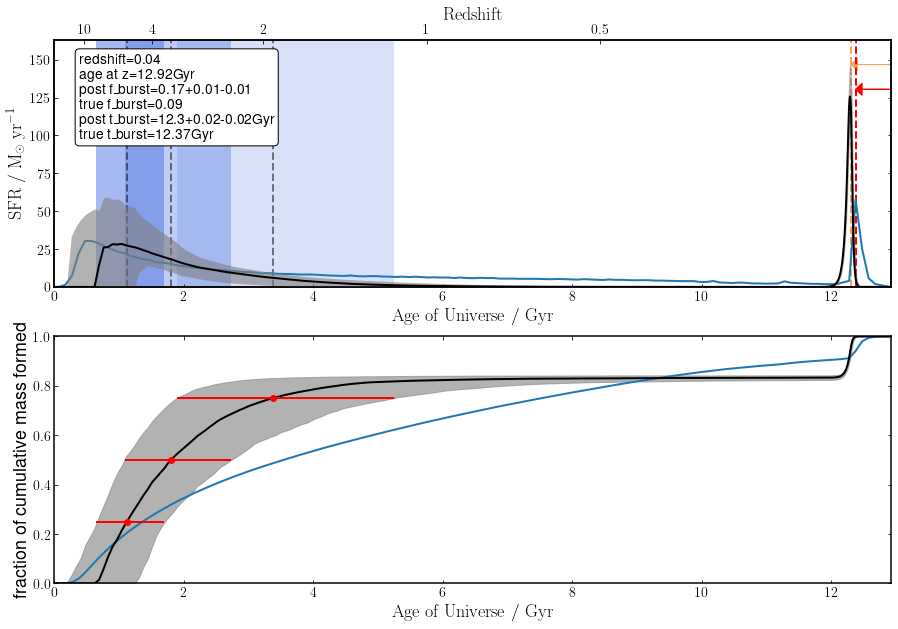

(<Figure size 1080x720 with 3 Axes>,
 array([<AxesSubplot:xlabel='$\\mathrm{Age\\ of\\ Universe\\ /\\ Gyr}$', ylabel='$\\mathrm{SFR\\ /\\ M_\\odot\\ \\mathrm{yr}^{-1}}$'>,
        <AxesSubplot:xlabel='$\\mathrm{Age\\ of\\ Universe\\ /\\ Gyr}$', ylabel='fraction of cumulative mass formed'>],
       dtype=object))

In [33]:
plot_sfh(fit, model_ages, model_sfh, ID, runID)

This looks great! The remaining difference, expecially in tburst, might be due to the shape of the simulated SFH that can never be fully captured with the psb2 functional form. So instead, we should fit the true SFH with the psb2 functional form, and use the exp metallicity scatter to create a new spectrum, then fit that spectrum with psb2 SFH component and exp scatter.

## Fitting true SFH with psb2 and creating spectrum with exp scatter

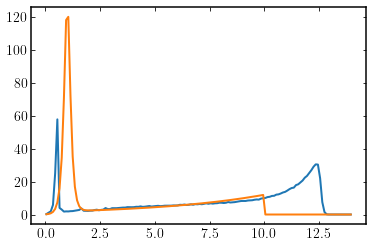

In [34]:
# a test run with random parameters
predict_sfh = psb_wild2020(model_ages, 10, 5, 1, 100, 100, 0.5, 11)
plt.plot(model_ages, model_sfh)
plt.plot(model_ages, predict_sfh)

[1.26818189e+01 4.18757126e+00 5.49999954e-01 1.93479148e+02
 4.59486377e+02 8.99312201e-02 1.10132437e+01]


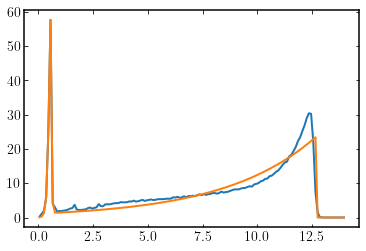

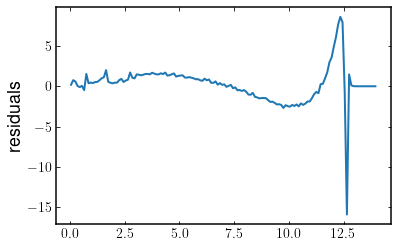

In [35]:
# using scipy curve fit to get a fit to the true SFH
popt,pcov = scipy.optimize.curve_fit(psb_wild2020, model_ages, model_sfh, 
                                     bounds=([10,1,0,10,10,0,10],[13,10,2,1000,1000,1,12]))
# best fits
print(popt)

predict_sfh = psb_wild2020(model_ages, *popt)
plt.plot(model_ages, model_sfh)
plt.plot(model_ages, predict_sfh)
plt.show()
plt.plot(model_ages, model_sfh-predict_sfh)
plt.ylabel('residuals')
plt.show()

In [38]:
# load in true spectrum
spectrum = np.loadtxt(fname="../../Yirui_test_cube/snap119/with_PSF/no_dust/Spectrum_2xSc_07_EC_BH_vw1e4_ReposNoRFBNoRP_with_PSF_no_dust_SNR15_outshining_test.csv", delimiter=',', skiprows=1)
spectrum[:,1] = spectrum[:,1]*10**-16
wavelengths = spectrum[:,0]

# generate the spectrum from best fit
psb = {}
psb['massformed'] = popt[-1]
psb['metallicity'] = 1.0 # solar metallicity
psb['age'] = popt[0]
psb['tau'] = popt[1]
psb['burstage'] = popt[2]
psb['alpha'] = popt[3]
psb['beta'] = popt[4]
psb['fburst'] = popt[5]

model_components = {}
model_components['psb_wild2020'] = psb
model_components['redshift'] = 0.04

pipes.config.Rspec = 10000
best_fit_model = pipes.model_galaxy(model_components, spec_wavs=wavelengths)

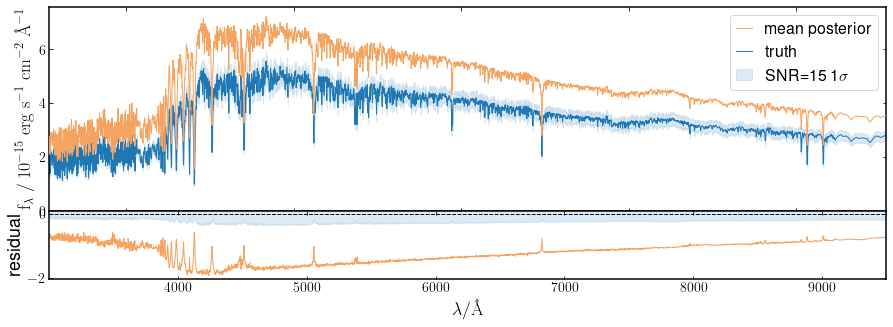

In [39]:
def plot_spec(wavelengths, true_spec, model_spec, limit_to_9500=False):
    if limit_to_9500:
        to_ind = [wavelengths<9500]
        wavelengths = wavelengths[to_ind]
        true_spec = true_spec[to_ind]
        model_spec = model_spec[to_ind]
    fig = plt.figure(figsize=[15,5])
    gs = fig.add_gridspec(4,1, hspace=0, wspace=0)
    ax1 = plt.subplot(gs[:-1])
    ax2 = plt.subplot(gs[-1])

    y_scale = pipes.plotting.add_spectrum(model_spec, ax1, label='mean posterior', lw=1)
    ax1.plot(wavelengths, true_spec[:,1]*10**-y_scale, label='truth', lw=1)
    ax1.fill_between(wavelengths, true_spec[:,1]*10**-y_scale-true_spec[:,1]*10**-y_scale/15, 
                     true_spec[:,1]*10**-y_scale+true_spec[:,1]*10**-y_scale/15,
                    color='C0', alpha=0.15, zorder=-1, label=r'SNR=15 1$\sigma$')
    ax1.legend()

    ax2.axhline(0, color="black", ls="--", lw=1)
    ax2.plot(wavelengths, (true_spec[:,1] - model_spec[:,1])*10**-y_scale, color='sandybrown', lw=1)
    ylims = ax2.get_ylim()
    ax2.fill_between(wavelengths, -true_spec[:,1]*10**-y_scale/15, true_spec[:,1]*10**-y_scale/15,
                    color='C0', alpha=0.15, zorder=-1, label=r'SNR=15 1$\sigma$')
    ax2.set_xlim(ax1.get_xlim())
    ax2.set_ylim(ylims)
    ax2.set_xlabel("$\\lambda / \\mathrm{\\AA}$")
    ax2.set_ylabel('residual')

    plt.show()
    
plot_spec(wavelengths, spectrum, best_fit_model.spectrum, limit_to_9500=True)

In [41]:
SNR = 15
spectrum_1sigma = best_fit_model.spectrum[:,1]*10**16/SNR
new_spectrum = pd.DataFrame({'observed-wave[AA]': best_fit_model.spectrum[:,0],
                             'flux[10^-16 erg/s/cm^2/AA]': best_fit_model.spectrum[:,1]*10**16,
                             'noise[10^-16 erg/s/cm^2/AA]': spectrum_1sigma})
new_spectrum.to_csv('best_fit_datacube_summed_exp_scatter_no_dust_SNR15_no_perturbation.csv', index=False)

In [42]:
# now fit the newly created exp scatter spectrum
def load_uds_spectrum_mask(ID,z):

    # load spectral data
    spectrum = np.loadtxt(fname=
                          ID+".csv", delimiter=',', skiprows=1)
    
    spectrum[:,1] *= 10**-16
    spectrum[:,2] *= 10**-16

    # blow up the errors associated with any bad points in the spectrum and photometry
    for i in range(len(spectrum)):
        if spectrum[i,1] == 0 or spectrum[i,2] <= 0:
            spectrum[i,1] = 0.
            spectrum[i,2] = 9.9*10**99.
    
    # nebular emission lines and interstellar absorption lines
    mask = mask_em(spectrum[:,0]/(1+z))
    spectrum[mask, 2] = 9.9*10**99.
    
    # O2 telluric
    mask = ((spectrum[:,0] > 7580.) & (spectrum[:,0] < 7650.))
    spectrum[mask, 2] = 9.9*10**99.

    #return bin(spectrum,4)
    return spectrum

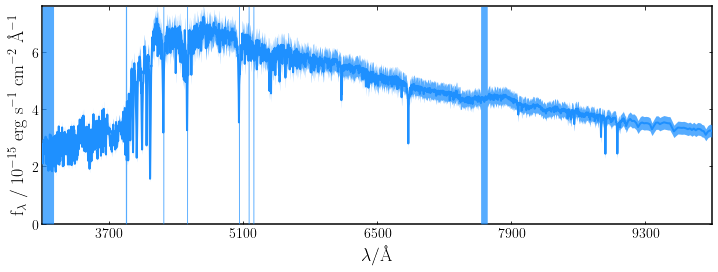

In [43]:
ID = 'best_fit_datacube_summed_exp_scatter_no_dust_SNR15_no_perturbation'
z = 0.04

galaxy = pipes.galaxy(ID, load_uds_mask, photometry_exists=False)

fig = galaxy.plot()

In [44]:
fit_instructions = get_fit_instructions()
print(fit_instructions)

{'psb2': {'age': (4, 14.0), 'tau': (0.3, 10.0), 'massformed': (6, 13), 'metallicity': (0.01, 2.5), 'metallicity_prior': 'log_10', 'burstage': (0, 2), 'alpha': (0.01, 1000), 'alpha_prior': 'log_10', 'beta': 250.0, 'fburst': (0, 1)}, 'redshift': (0.032, 0.048)}


In [45]:
pipes.config.Rspec = 4340
runID = "exp_scatter_best_fit_SFH_no_dust_bin_by_1_4340_Rspec"
fit = pipes.fit(galaxy, fit_instructions, run=runID)

fit.fit(verbose=False)


Bagpipes: fitting object best_fit_datacube_summed_exp_scatter_no_dust_SNR15_no_perturbation


Completed in 2770.3 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
psb2:age                      10.168     11.547     12.492
psb2:alpha                   241.770    438.736    752.254
psb2:burstage                  0.422      0.439      0.494
psb2:fburst                    0.081      0.086      0.094
psb2:massformed               10.954     10.978     11.000
psb2:metallicity               0.988      1.046      1.105
psb2:tau                       3.092      4.452      6.458
redshift                       0.040      0.040      0.040




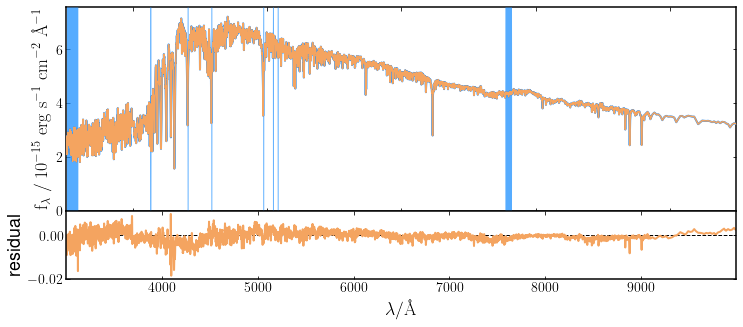

In [46]:
# Make the figure
matplotlib.rcParams.update({'font.size': 16})
params = {'legend.fontsize': 16,
          'legend.handlelength': 1}
matplotlib.rcParams.update(params)
matplotlib.rcParams['text.usetex'] = True
fit.posterior.get_advanced_quantities()

naxes=1
fig = plt.figure(figsize=(12, 5.*naxes))

gs1 = matplotlib.gridspec.GridSpec(4, 1, hspace=0., wspace=0.)
ax1 = plt.subplot(gs1[:3])
ax3 = plt.subplot(gs1[3])

mask = fit.galaxy.spectrum[:, 2] < 1.
fit.galaxy.spectrum[mask, 2] = 0.

y_scale = pipes.plotting.add_spectrum(fit.galaxy.spectrum, ax1)
pipes.plotting.add_spectrum_posterior(fit, ax1, y_scale=y_scale)

post_median = np.median(fit.posterior.samples["spectrum"], axis=0)

#ax1.plot(fit.galaxy.spectrum[:,0],
#         post_median*10**-y_scale,
#         color="black", lw=1.0,zorder=11)

ax3.axhline(0, color="black", ls="--", lw=1)
ax3.plot(fit.galaxy.spectrum[:,0],(post_median - fit.galaxy.spectrum[:,1])*10**-y_scale, color="sandybrown")
#ax1.set_xlim([3000,4200])
ax3.set_xlim(ax1.get_xlim())
ax3.set_xlabel("$\\lambda / \\mathrm{\\AA}$")
ax3.set_ylabel('residual')
fig.savefig('pipes/plots/'+runID+'/'+ID+'_fit.pdf')
plt.show()

In [47]:
fig = fit.plot_corner(save=True, show=True)

only recovered 0.8450303691270131 of total mass formed.
10.939866995579566 11.012994678455579
model f_burst and t_burst: 0.11665119900666596 12.374068460508958
model f_burst and t_burst: 0.11665119900666596 12.374068460508958
posterior f_burst and t_burst: [0.08129664 0.08654834 0.09407118] [12.42935911 12.48351734 12.50225147]


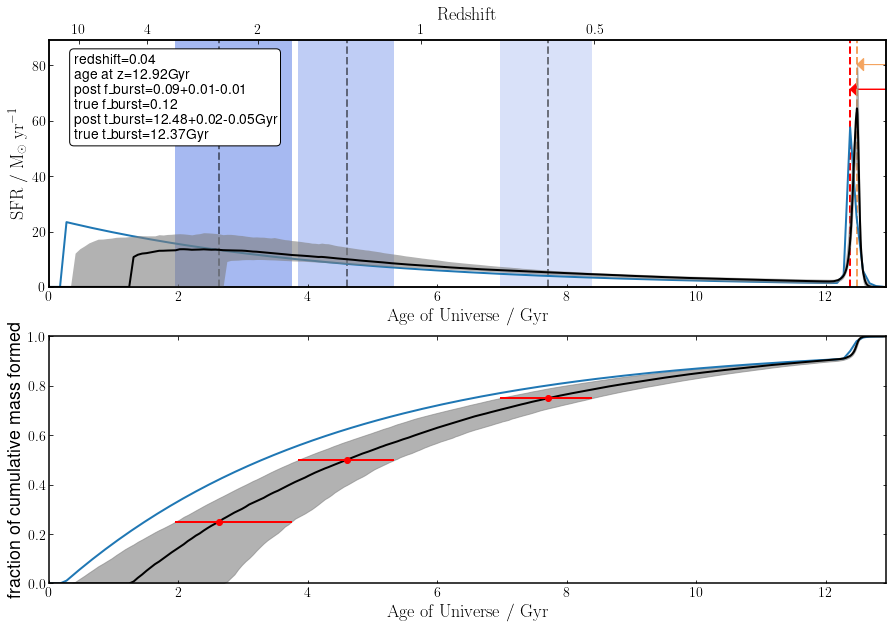

(<Figure size 1080x720 with 3 Axes>,
 array([<AxesSubplot:xlabel='$\\mathrm{Age\\ of\\ Universe\\ /\\ Gyr}$', ylabel='$\\mathrm{SFR\\ /\\ M_\\odot\\ \\mathrm{yr}^{-1}}$'>,
        <AxesSubplot:xlabel='$\\mathrm{Age\\ of\\ Universe\\ /\\ Gyr}$', ylabel='fraction of cumulative mass formed'>],
       dtype=object))

In [48]:
plot_sfh(fit, model_ages, predict_sfh, ID, runID)

In [56]:
fit.posterior.sfh.component_weights


{'psb2': array([1.78342716e+04, 4.63849683e+03, 5.87290362e+03, 7.44679945e+03,
        9.46005668e+03, 1.20457629e+04, 1.53834883e+04, 1.97191010e+04,
        2.53950545e+04, 3.28978515e+04, 4.29344418e+04, 5.65588194e+04,
        7.53885670e+04, 1.01988485e+05, 1.40577350e+05, 1.98388653e+05,
        2.88424826e+05, 4.35360044e+05, 6.89051768e+05, 1.15792198e+06,
        2.09912586e+06, 4.18915217e+06, 9.44446272e+06, 2.48650880e+07,
        7.97750877e+07, 3.29120572e+08, 1.79082116e+09, 5.25450931e+09,
        1.51866520e+09, 2.98663346e+08, 3.09977742e+08, 4.32709363e+08,
        6.24748814e+08, 9.34739326e+08, 1.46275316e+09, 2.42237547e+09,
        4.30866101e+09, 8.38734209e+09, 1.82984913e+10, 4.07944451e+10,
        0.00000000e+00, 0.00000000e+00])}

In [60]:
fit.posterior.sfh.ceh.grid


array([[1.64216009e+02, 4.27107681e+01, 5.40770499e+01, 6.85693094e+01,
        8.71071603e+01, 1.10916058e+02, 1.41649466e+02, 1.81571310e+02,
        2.33834866e+02, 3.02919794e+02, 3.95335613e+02, 5.20787381e+02,
        6.94169624e+02, 9.39098739e+02, 1.29442076e+03, 1.82674088e+03,
        2.65578404e+03, 4.00874735e+03, 6.34471281e+03, 1.06620181e+04,
        1.93285198e+04, 3.85732519e+04, 8.69635728e+04, 2.28954992e+05,
        7.34560224e+05, 3.03050599e+06, 1.64896840e+07, 4.83829432e+07,
        1.39837019e+07, 2.75005920e+06, 2.85424091e+06, 3.98434017e+06,
        5.75261829e+06, 8.60697679e+06, 1.34688700e+07, 2.23049666e+07,
        3.96736762e+07, 7.72297225e+07, 1.68490493e+08, 3.75630759e+08,
        0.00000000e+00, 0.00000000e+00],
       [1.56125080e+03, 4.06064067e+02, 5.14126713e+02, 6.51908966e+02,
        8.28153868e+02, 1.05451219e+03, 1.34670391e+03, 1.72625284e+03,
        2.22313812e+03, 2.87994923e+03, 3.75857410e+03, 4.95128165e+03,
        6.59967857e+03,